In [65]:
from pathlib import Path
import json
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

In [66]:
def load_spreads():
    spreads_path = Path('/home/ross/coding/modular_trader/market_data/spreads.json')

    with open(spreads_path, 'r') as f:
        data = json.load(f)

    spreads_df = pd.DataFrame().from_dict(data, orient='index')
    spreads_df['timestamp'] = pd.to_datetime(spreads_df.index, format='%d/%m/%y %H:%M')
    spreads_df = spreads_df.set_index('timestamp', drop=True)
    spreads_df = spreads_df.sort_index()
    spreads_df = spreads_df.resample('H').agg('mean')

    return spreads_df

In [82]:
spreads = load_spreads()

In [129]:
med = spreads.rolling(3).mean().median(axis=1)
new = pd.DataFrame({'med_spread': med, 
                    'roc_1': med.pct_change(), 
                    'roc_4': med.pct_change(4), 
                    'roc_12': med.pct_change(12), 
                    'roc_day': med.pct_change(24), 
                    'roc_week': med.pct_change(168)})

new['hour'] = new.index.hour
new['day'] = new.index.dayofweek

/tmp/ipykernel_3781996/2349821768.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  'roc_1': med.pct_change(),
/tmp/ipykernel_3781996/2349821768.py:4: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  'roc_4': med.pct_change(4),
/tmp/ipykernel_3781996/2349821768.py:5: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  'roc_12': med.pct_change(12),
/tmp/ipykernel_3781996/2349821768.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future vers

In [133]:
new.tail(30).head(15)

,med_spread,roc_1,roc_4,roc_12,roc_day,roc_week,hour,day
timestamp,,,,,,,,
2024-01-11 05:00:00,0.000745,0.035322,0.007933,-0.110171,-0.077501,0.236156,5,3
2024-01-11 06:00:00,0.000793,0.064114,0.100595,-0.072297,0.004924,0.280205,6,3
2024-01-11 07:00:00,0.000817,0.030251,0.141858,-0.102437,0.080181,0.320692,7,3
2024-01-11 08:00:00,0.000822,0.006945,0.142912,-0.204836,0.080498,0.279714,8,3
2024-01-11 09:00:00,0.000811,-0.014151,0.088297,-0.268315,0.058144,0.246804,9,3
2024-01-11 10:00:00,0.000806,-0.005476,0.017126,-0.196157,0.057026,0.219218,10,3
2024-01-11 11:00:00,0.000792,-0.017744,-0.030258,-0.076529,0.036993,0.253632,11,3
2024-01-11 12:00:00,0.000756,-0.045569,-0.080831,0.014758,-0.014433,0.141379,12,3
2024-01-11 13:00:00,0.000707,-0.064428,-0.127708,-0.043156,-0.151514,0.097569,13,3


<Axes: xlabel='timestamp'>

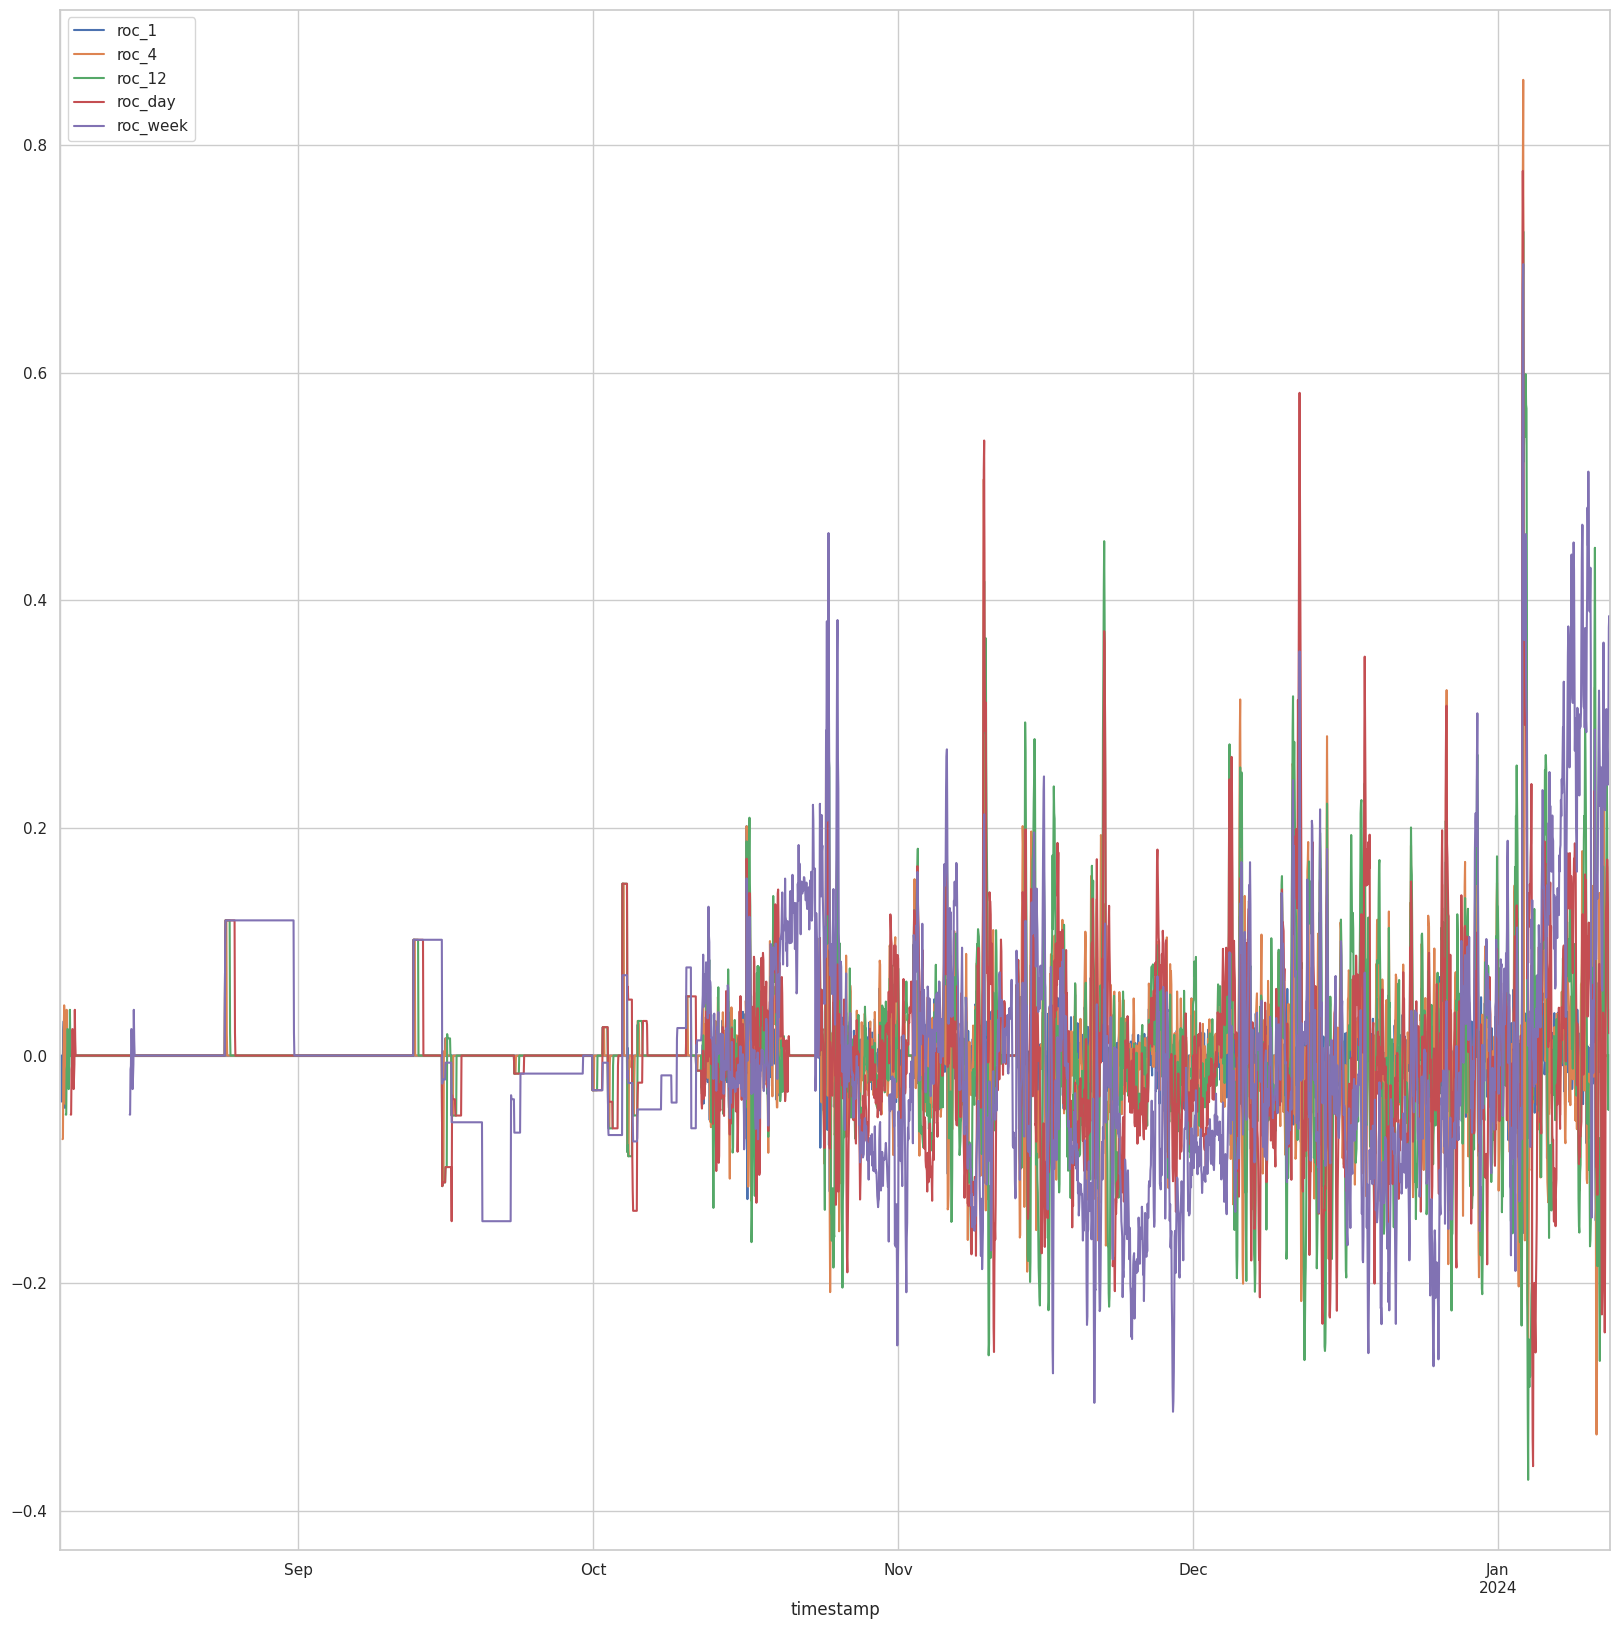

In [99]:
new.drop(['med_spread', 'hour', 'day'], axis=1).plot(figsize=(20, 20))

In [100]:
new = new.dropna(axis=0)

In [101]:
X = new.drop(['med_spread', 'roc_1'], axis=1)
y = new.roc_1
z = new.med_spread

In [102]:
split = int(len(X) * 0.9)
X_train = X.iloc[:split, :]
X_test = X.iloc[split:, :]
y_train = y.iloc[:split]
y_test = y.iloc[split:]
z_train = z.iloc[:split]
z_test = z.iloc[split:]

In [88]:
rfr = RandomForestRegressor(n_estimators=100)
rfr.fit(X_train, y_train)

RandomForestRegressor()

In [89]:
rfr_pred = rfr.predict(X_test)

In [94]:
results = pd.DataFrame({'real': y_test, 'pred': rfr_pred})
results

,real,pred
timestamp,,
2024-01-03 10:00:00,-0.025556,-0.005612
2024-01-03 11:00:00,0.065186,0.021070
2024-01-03 12:00:00,0.543624,0.107532
2024-01-03 13:00:00,0.107139,0.103204
2024-01-03 14:00:00,0.020286,0.106694
...,...,...
2024-01-11 15:00:00,0.037275,-0.019674
2024-01-11 16:00:00,0.148115,0.016324
2024-01-11 17:00:00,0.084589,0.041409


<Axes: xlabel='timestamp'>

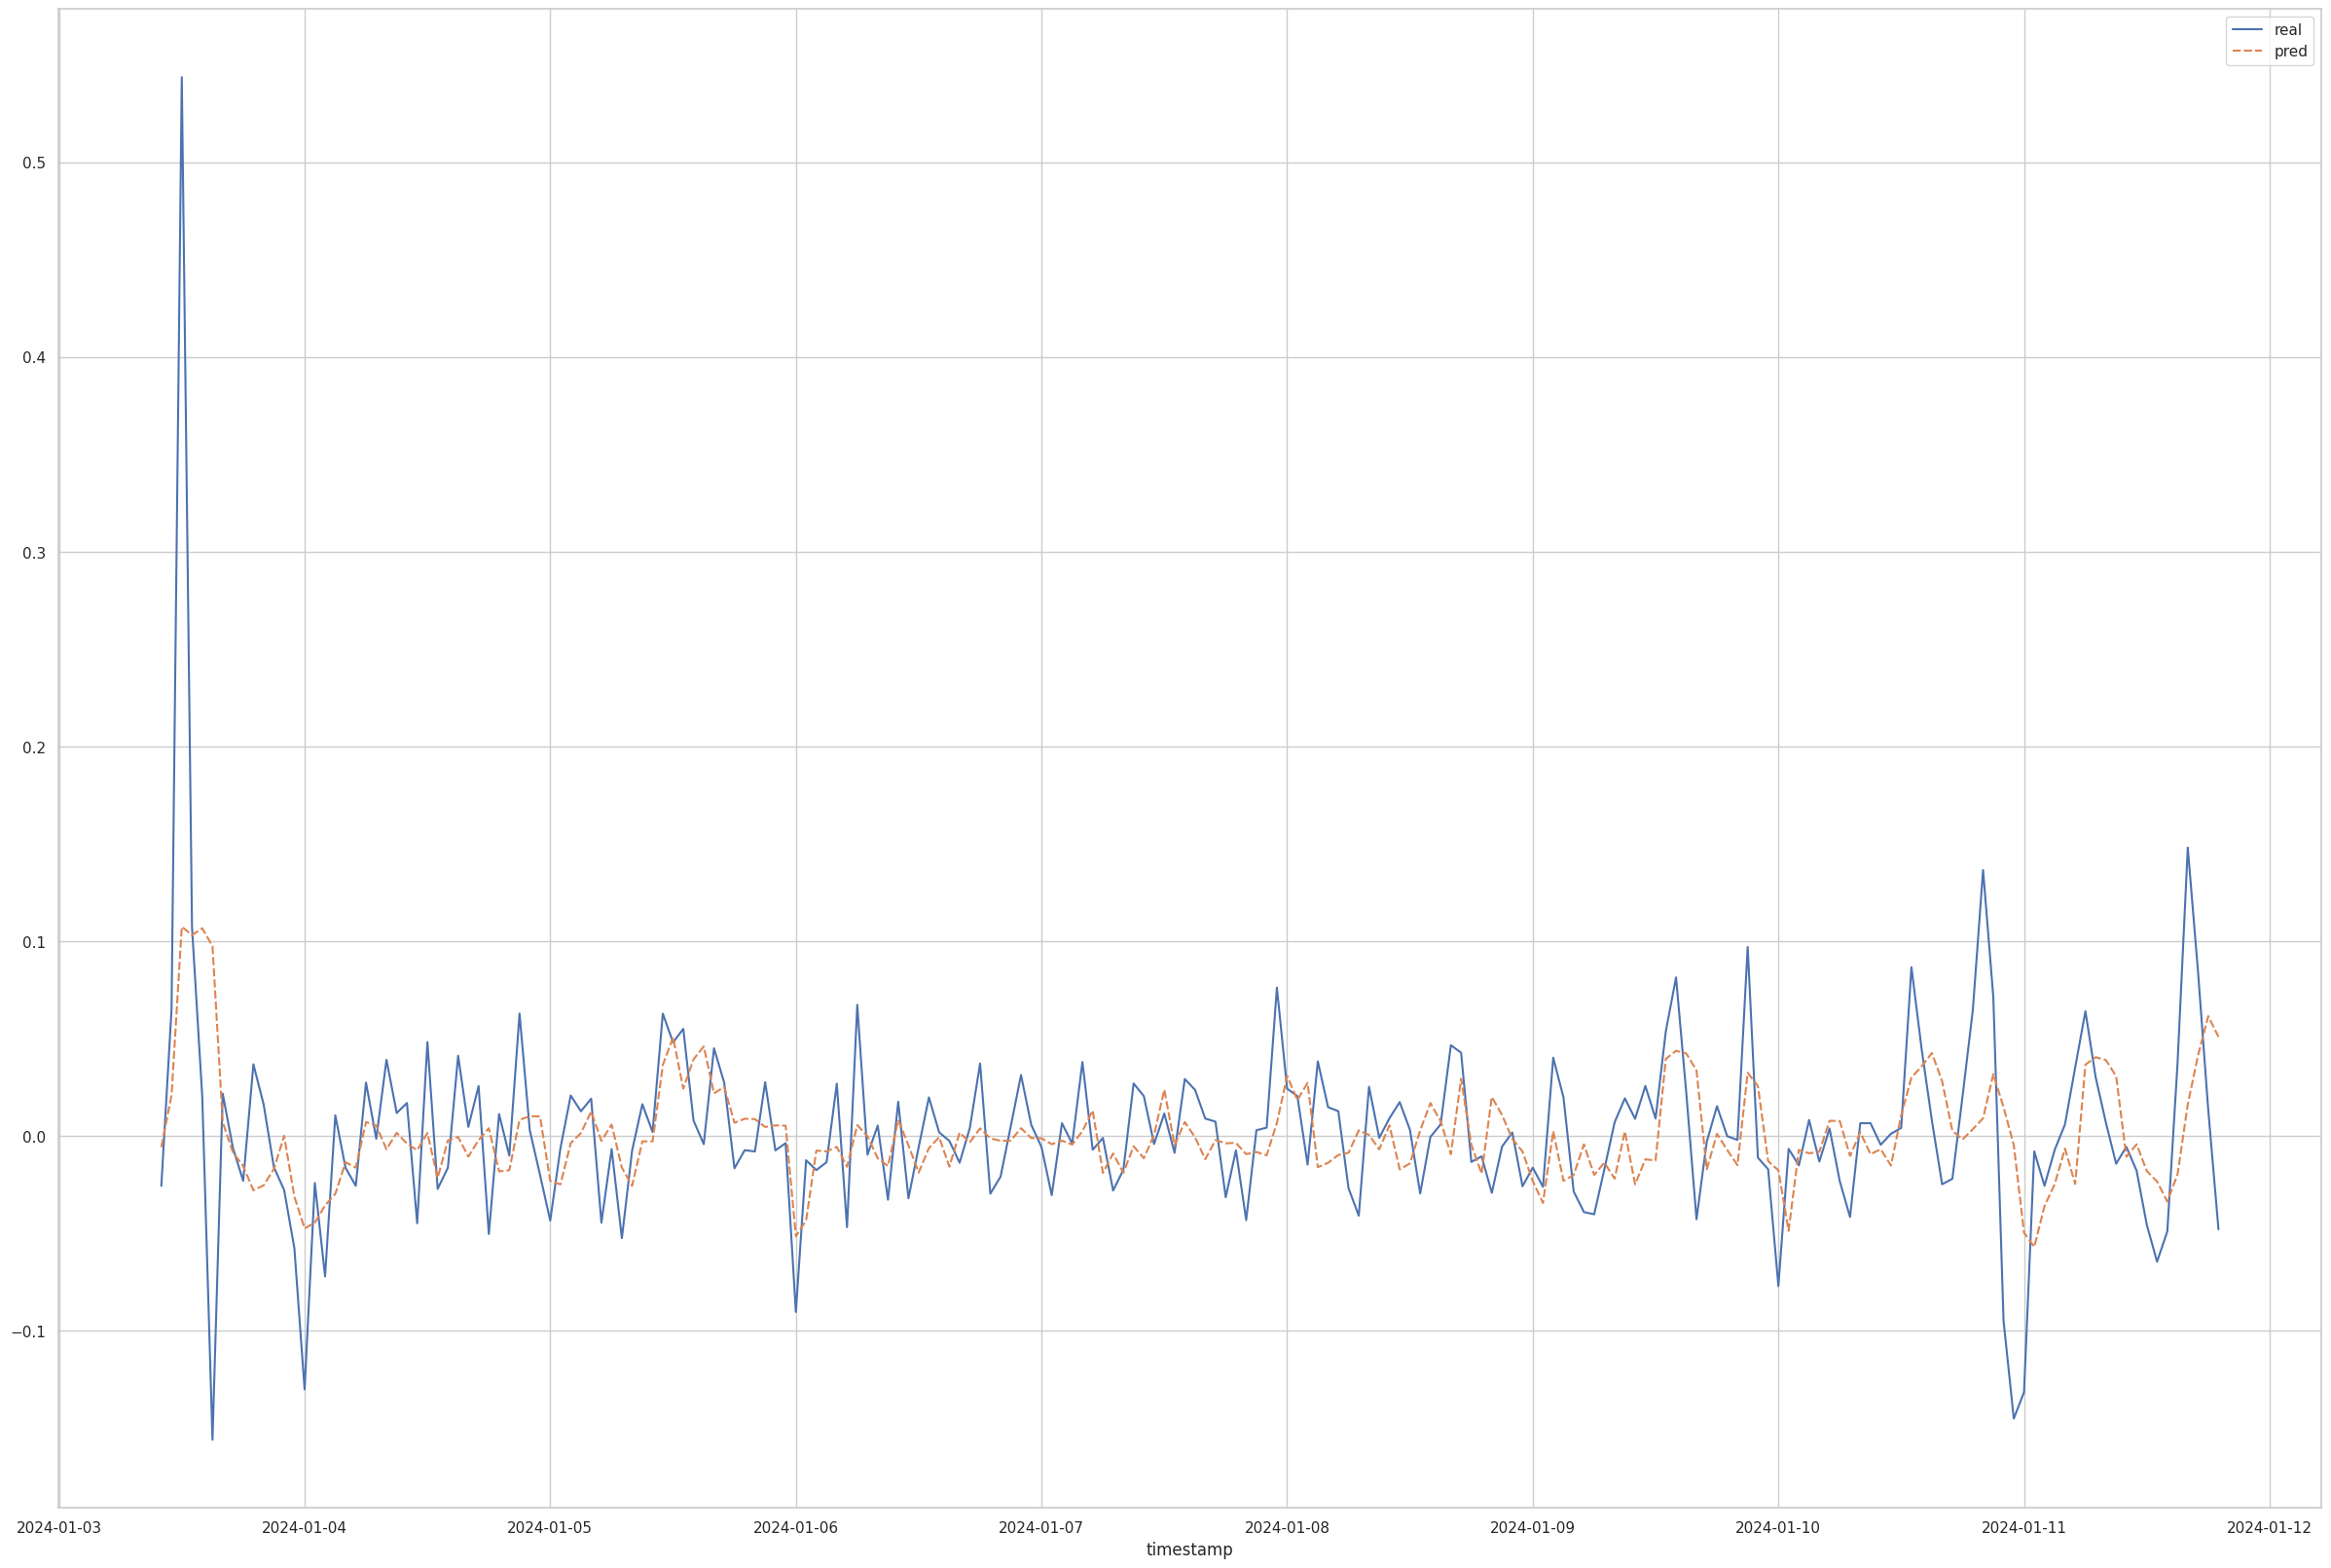

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 20))
sns.set(style='whitegrid')
sns.lineplot(data=results)

In [105]:
test = new[['med_spread', 'roc_1']]
test

,med_spread,roc_1
timestamp,,
2023-08-24 13:00:00,0.000939,0.096827
2023-08-24 14:00:00,0.000957,0.020019
2023-09-12 17:00:00,0.001055,0.101736
2023-09-15 15:00:00,0.000934,-0.114704
2023-09-15 16:00:00,0.000937,0.003700
...,...,...
2024-01-11 15:00:00,0.000698,0.037275
2024-01-11 16:00:00,0.000801,0.148115
2024-01-11 17:00:00,0.000869,0.084589


In [114]:
test_2 = test.med_spread.shift() * (1 + test.roc_1)

In [121]:
def calc_next(spread, roc):
    """given current spread and predicted roc, calculate next spread"""
    return spread *  (1 + roc)

In [123]:
print(calc_next(test, 0))

0.0009574657832048795


In [124]:
compare = pd.DataFrame({'real_val': z_test, 'real_roc': y_test, 'pred_roc': rfr_pred})

In [125]:
compare

,real_val,real_roc,pred_roc
timestamp,,,
2024-01-03 10:00:00,0.000534,-0.025556,-0.005612
2024-01-03 11:00:00,0.000569,0.065186,0.021070
2024-01-03 12:00:00,0.000878,0.543624,0.107532
2024-01-03 13:00:00,0.000972,0.107139,0.103204
2024-01-03 14:00:00,0.000992,0.020286,0.106694
...,...,...,...
2024-01-11 15:00:00,0.000698,0.037275,-0.019674
2024-01-11 16:00:00,0.000801,0.148115,0.016324
2024-01-11 17:00:00,0.000869,0.084589,0.041409


<Axes: xlabel='timestamp'>

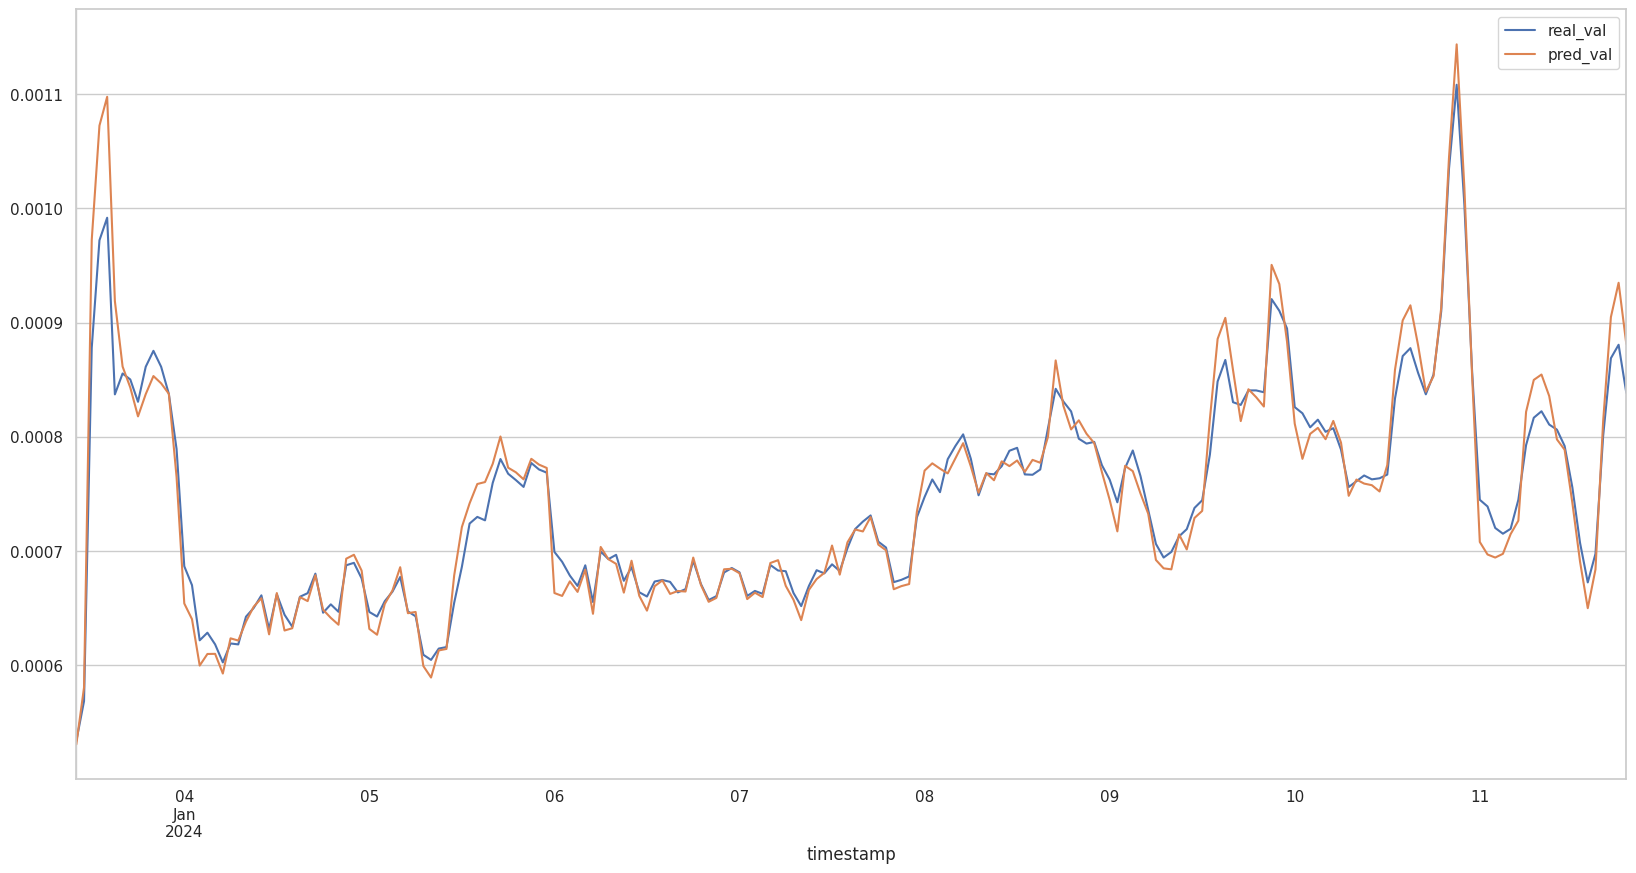

In [128]:
compare['pred_val'] = compare.real_val * (1 + compare.pred_roc)
compare[['real_val', 'pred_val']].plot(figsize=(20, 10))